# Librerias

In [2]:
!pip install keras-tuner -q

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import time
from tensorflow import keras
import keras_tuner
from tensorflow.keras import layers
from keras.utils import normalize
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/db_b'
!ls

/content/drive/MyDrive/db_b
Monilia  Sana


# Carga y analisis de dataset

In [ ]:
#obtener directorio de db
fpath = '/content/drive/MyDrive/db_b'
categories = os.listdir(fpath)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['Sana', 'Monilia'] 

No. of categories =  2


In [ ]:
#cargar imagenes y etiquetas
def load_images_and_labels(categories):
    img_lst=[]
    img_names=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (312, 416))
            img_array = Image.fromarray(img, 'RGB')
    
            img_lst.append(np.array(img_array)) 
            img_names.append(image_name)       
            labels.append(index)
    return img_lst, img_names, labels

images, name_images, labels = load_images_and_labels(categories)
print("Nro. de imagenes cargadas = ",len(images), "\nNro. de nombre imagenes cargadas = ",len(name_images), "\nNro. de etiquetas cargadas = ",len(labels))
print(type(images),type(labels))

Nro. de imagenes cargadas =  1840 
Nro. de nombre imagenes cargadas =  1840 
Nro. de etiquetas cargadas =  1840
<class 'list'> <class 'list'>


# Preparar imagenes

In [ ]:
#crear matriz de imagenes con sus etiquetas
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (1840, 416, 312, 3) 
Labels shape =  (1840,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
#funcion para mostrar imagenes
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Cacao : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()

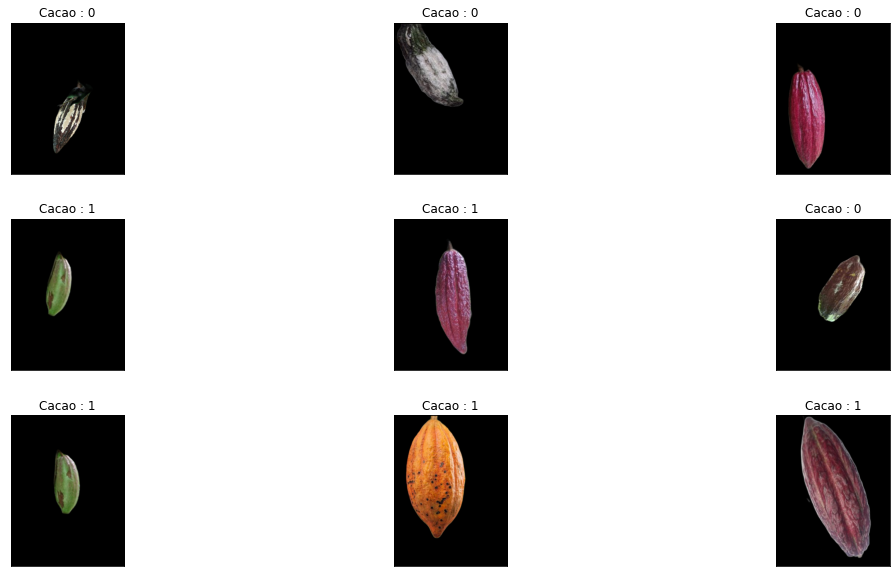

In [ ]:
#mostrar imagenes
display_rand_images(images, labels)

In [ ]:
#normalizar contenido de listas
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

# Division de datos de entrenamiento, prueba y validación

In [ ]:
#dividir datos de prueba
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=1)
for train_index, test_index in sss.split(images, labels):
  print("TRAIN:", train_index, "TEST:", test_index,"\n")
  x_train, x_test = images[train_index], images[test_index]
  y_train, y_test = labels[train_index], labels[test_index]

TRAIN: [ 537  403  644 ... 1761 1445 1234] TEST: [ 532  655  952 1194 1146  178  888 1461  572  155    7  785 1408 1227
  715  166   64 1211 1793 1804   71 1590   10 1111 1675  860  751   15
  580  288  381  775  996  712 1705  695   20  278 1238 1718 1450  569
  566 1012 1608  648  514 1521  282 1204 1090   77  774  778  183  478
  176  279 1391  694 1463  461 1157  793  668 1639 1470  151  405 1045
  466 1763 1819 1084 1108  984 1169 1086  852 1515 1300 1746 1134 1612
  728 1485  418  193 1333 1023 1582  946  390 1054 1501 1610 1076  595
  398  276  665 1664  231 1403  615 1402 1393  235 1834 1814   86  621
   25  327   75 1566 1765 1162 1196 1615  141 1140  627   22  609 1555
  534 1105  626 1727 1642  880  752  997 1314 1502  706  693 1174  767
  348 1019 1773 1181  951   37  927 1697 1006  302  454  564 1439  508
  747   72  954  606  468 1776 1686  476  196 1290 1034  209  215  847
  264  988  633 1357  485  401 1016 1643  962  489  937 1640  252  913
  660 1336 1327 1107  859  3

In [ ]:
#comprobar forma de datos
print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (1472, 416, 312, 3)
y_train shape =  (1472,)

x_test shape =  (368, 416, 312, 3)
y_test shape =  (368,)


In [ ]:
#comprobar equilibrio de clases
list_y_train= y_train.tolist()
list_y_test = y_test.tolist()
print(list_y_train.count(0),list_y_train.count(1))
print(list_y_test.count(0),list_y_test.count(1))

736 736
184 184


In [ ]:
print(y_train)

[0 1 1 ... 1 1 0]


In [ ]:
#obtener indices
keys_y_train = np.argsort(y_train)

In [ ]:
print(keys_y_train)

[  0 792 794 ... 606 958 235]


In [ ]:
#reasignar indices correspondientes en las listas declaradas
x_train = x_train[keys_y_train]
y_train = y_train[keys_y_train]

print("Images shape after shuffling = ",x_train.shape,"\nLabels shape after shuffling = ",y_train.shape)

Images shape after shuffling =  (1472, 416, 312, 3) 
Labels shape after shuffling =  (1472,)


In [ ]:
print(y_train)

[0 0 0 ... 1 1 1]


In [ ]:
#dividir datos de validacion
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=1)
for train_index, val_index in sss.split(x_train, y_train):
  print("TRAIN:", train_index, "TEST:", val_index)
  xf_train, x_val = x_train[train_index], x_train[val_index]
  yf_train, y_val = y_train[train_index], y_train[val_index]

TRAIN: [1194 1411  639 ... 1159  929 1384] TEST: [1406  900 1435 1340   20   43  387 1222 1064  278  896  243 1073  762
  633  508  497  595  914 1286 1269 1330  542 1199  210  193  381  209
 1208 1110  566   71  853  665  588  568  583  695  126 1124  778 1300
   15 1193  863 1259  297  741 1377  923 1202  469  390  911  231   77
  176 1386  627  282 1464 1304 1062  130 1339  503 1380 1438  737  618
  317 1425 1123  599 1147  677  669  405  468  997   72  178  738 1043
  950 1185 1195  144 1007 1290  699 1385 1312 1296 1036 1391  625  505
 1184  747 1353  825  813 1017  357  804   96  316  915 1414 1293  992
 1151  668  629 1349  743  688 1044 1422  692 1321 1177  151 1448  971
  393  655 1404 1436 1437  263  873  492  183 1212  728  872   10  281
  398 1301  466  279 1266  416  865  800  149  653 1303 1169  908  993
 1228  645 1052  514  196 1117 1068  170  431  129  215 1387  470  356
  348  253  616  569  155   86  910  490  369  141  690  269 1285  831
  562  586  974  687   22 14

In [ ]:
list_yf_train=yf_train.tolist()
list_y_val = y_val.tolist()
print(list_yf_train.count(0),list_yf_train.count(1))
print(list_y_val.count(0),list_y_val.count(1))

589 588
147 148


In [ ]:
#comprobar forma de los datos de entrenamiento, prueba y validacion
print("x_train shape = ",xf_train.shape)
print("y_train shape = ",yf_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

x_train shape =  (1177, 416, 312, 3)
y_train shape =  (1177, 2, 2)

x_test shape =  (368, 416, 312, 3)
y_test shape =  (368, 2, 2)

x_val shape =  (295, 416, 312, 3)
y_val shape =  (295, 2, 2)


In [ ]:
#escalamiento de datos
xf_train = normalize(xf_train, axis=1)
x_test = normalize(x_test, axis=1)
x_val = normalize(x_val, axis=1)

In [ ]:
#codificar etiquetas
yf_train = to_categorical(yf_train, 2 , dtype='int32')
y_test = to_categorical(y_test, 2, dtype='int32')
y_val = to_categorical(y_val, 2, dtype='int32')

# Modelo InceptionV3

In [ ]:
#instanciar modelo preentrenado
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=xf_train[0].shape, include_top=False, weights="imagenet")

#desactivar el entrenamiento por defecto en cada capa
for layer in pre_trained_model.layers:
  layer.trainable = False

#obtener capas
last_layer = pre_trained_model.get_layer('mixed10')
last_output = last_layer.output
#agregar capas de finales
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

#instancia completa del modelo
model2 = tf.keras.Model(pre_trained_model.input, x)

#compilar modelo
model2.compile(optimizer=keras.optimizers.Adam(), loss="binary_crossentropy", metrics=["accuracy"])

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
model2.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 416, 312, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': False,
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'linear',
    'use_bias': False,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'BatchNormalization

In [ ]:
#analizar optimizador modelo 
model2.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [ ]:
#regularizar modelo
es = EarlyStopping(monitor="val_accuracy", mode="min", patience=10, verbose=1)

In [ ]:
steps_per_epoch = (xf_train.shape[0]//32)
validation_steps = (x_val.shape[0]// 32)

# Entrenamiento

In [ ]:
#entrenar primer modelo
history2 = model2.fit(xf_train, yf_train,
    steps_per_epoch=steps_per_epoch,
    epochs = 30,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps,
    batch_size = 32,
    callbacks=[es],
    verbose=1)

Epoch 1/30
36/36 [==============================] - 409s 11s/step - loss: 1.2685 - accuracy: 0.7309 - val_loss: 1.0816 - val_accuracy: 0.6736
Epoch 2/30
36/36 [==============================] - 388s 11s/step - loss: 0.6407 - accuracy: 0.8087 - val_loss: 0.5505 - val_accuracy: 0.7674
Epoch 3/30
36/36 [==============================] - 389s 11s/step - loss: 0.3405 - accuracy: 0.8533 - val_loss: 0.3192 - val_accuracy: 0.8472
Epoch 4/30
36/36 [==============================] - 382s 11s/step - loss: 0.2189 - accuracy: 0.9048 - val_loss: 0.2941 - val_accuracy: 0.8681
Epoch 5/30
36/36 [==============================] - 387s 11s/step - loss: 0.1873 - accuracy: 0.9214 - val_loss: 0.2965 - val_accuracy: 0.8611
Epoch 6/30
36/36 [==============================] - 383s 11s/step - loss: 0.1703 - accuracy: 0.9301 - val_loss: 0.3089 - val_accuracy: 0.8681
Epoch 7/30
36/36 [==============================] - 383s 11s/step - loss: 0.1908 - accuracy: 0.9240 - val_loss: 0.2516 - val_accuracy: 0.9062
Epoch 

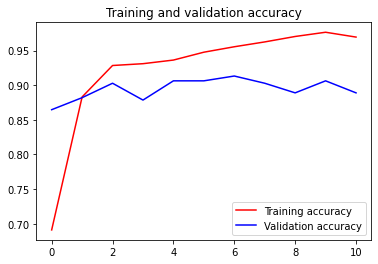

In [ ]:
accuracy = history2.history['accuracy']
validation_accuracy = history2.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('../MyDrive/entrenamiento.png')
plt.show()

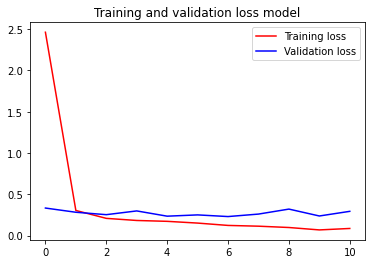

In [ ]:
accuracy = history2.history['loss']
validation_accuracy = history2.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training loss')
plt.plot(epochs, validation_accuracy, 'b', label='Validation loss')
plt.title('Training and validation loss model')
plt.legend()
plt.savefig('../MyDrive/perdidaTrain.png')
plt.show()

In [ ]:
#evaluar modelo
model2.evaluate(x_test,y_test,batch_size=32)

12/12 [==============================] - 112s 9s/step - loss: 0.2326 - accuracy: 0.8995


[0.2325998842716217, 0.8994565010070801]

In [ ]:
#obtener predicciones
y_pred = model2.predict(x_test,batch_size=32,verbose=0)

In [ ]:
#cambiar a 1 fila todas las predicciones
y_pred_reduce = np.argmax(y_pred, axis=1) 

#cambiar a 1 fila todas las etiquetas de prueba
y_test_reduced = np.argmax(y_test,axis=1)

In [ ]:
#encontrar metricas de evaluacion
accuracy = accuracy_score(y_test_reduced, y_pred_reduce)*100
precision = precision_score(y_test_reduced, y_pred_reduce, average='weighted')*100
recall = recall_score(y_test_reduced, y_pred_reduce, average='weighted')*100
f1 = f1_score(y_test_reduced, y_pred_reduce, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

Accuracy: 89.95
F1 score: 89.87
Precision: 91.11
Recall: 89.95


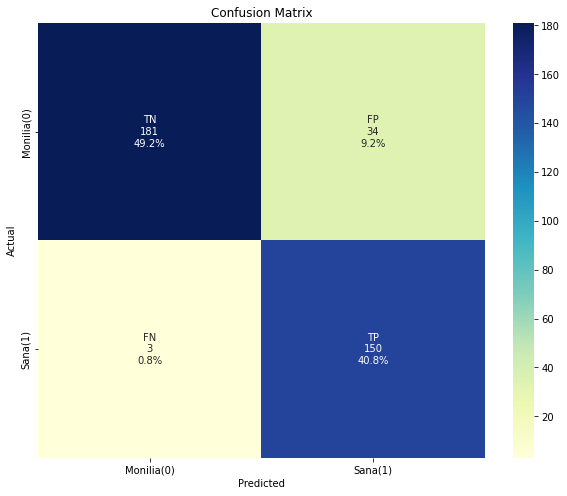

In [ ]:
plt.figure(figsize = (10,8))

classes = ["TN","FP","FN","TP"]
values = ["{0:0.0f}".format(x) for x in cm.flatten()]

# calcular y obtener valores
percentages = ["{0:.1%}".format(x) for x in cm.flatten()/np.sum(cm)]
combined = [f"{i}\n{j}\n{k}" for i, j, k in zip(classes, values, percentages)]
combined = np.asarray(combined).reshape(2,2)

# crear matriz
b = sns.heatmap(cm, annot=combined, fmt="", cmap='YlGnBu')
#etiquetas
b.set_xticklabels(['Monilia(0)','Sana(1)'],fontsize=10)
b.set_yticklabels(['Monilia(0)','Sana(1)'],fontsize=10)
b.set(title='Confusion Matrix')
b.set(xlabel='Predicted', ylabel='Actual',)
plt.savefig('../MyDrive/matrizconfusion.png')
plt.show()

In [ ]:
#metricas de evaluacion 2  (verificacion de clases)
print(classification_report(y_pred_reduce,y_test_reduced))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91       215
           1       0.82      0.98      0.89       153

    accuracy                           0.90       368
   macro avg       0.90      0.91      0.90       368
weighted avg       0.91      0.90      0.90       368



In [ ]:
"""CURVA ROC"""
#realizar predicciones del conjunto de prueba
y_predsroc = model2.predict(x_test).ravel()     

12/12 [==============================] - 110s 9s/step


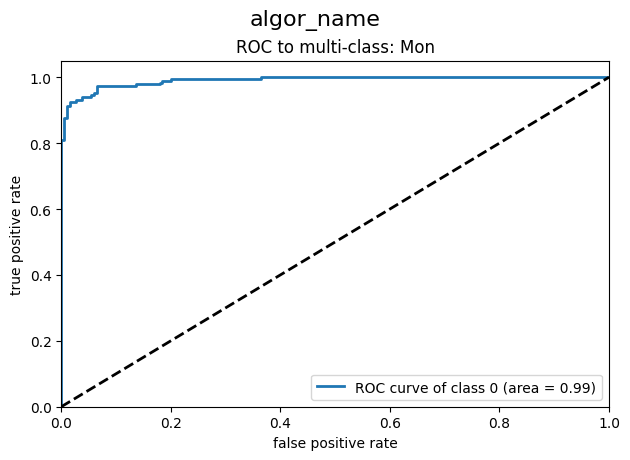

In [ ]:
# Compute ROC curve and ROC area for each class
yhat=y_test.reshape(-1,1)
n_classes = yhat.shape[1]
fig=plt.figure()
plt.style.use('default')
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="lower right", prop={'size': 10})
plt.title('ROC to multi-class: ' + "Mon")
plt.suptitle("algor_name", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()